## Ordinal Logistic Regression Model

**Andrew Ross, Sophie Hilgard, Reiko Nishihara, Nick Hoernle**

The ordinal logistic regression model is a generalized linear model specially tailored for the case of predicting descrete ordinal variables. It can be seen as an extension of the logistic regression model to the ordinal setting.

In [2]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import ast
%matplotlib inline

import mord

In [19]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

## Predicting business sucess (stars for a business)

In [20]:
# interesting columns
columns_of_interest = ['business_id',
                     'attributes',
                     'categories',
                     'city',
#                      'hours', # looks complicated
                     'latitude',
                     'longitude',
                     'neighborhoods',
                     'open',
                     'review_count',
                     'stars']
phoenix_restaurants = phoenix_restaurants[columns_of_interest]

def flatten(dct, separator='_'):
    """A fast way to flatten a dictionary,"""
    res = {}
    queue = [('', dct)]

    while queue:
        prefix, d = queue.pop()
        for k, v in d.items():
            key = prefix + k
            if not isinstance(v, dict):
                res[key] = [v]
            else:
                queue.append((key + separator, v))
    return res

def parse_data(row):
    attribs = flatten(ast.literal_eval(row.attributes))
    categories = ast.literal_eval(row.categories)
    neighborhoods = ast.literal_eval(row.neighborhoods)
    attributes = pd.DataFrame.from_dict(attribs, orient='columns')
    categories = pd.DataFrame.from_dict(dict([[c, [1]] for c in categories]))
    neighborhoods = pd.DataFrame.from_dict(dict([[n, [1]] for n in neighborhoods]))
    
    row = row.drop(['attributes', 'categories', 'neighborhoods'])
    if (neighborhoods.shape[0] > 0) & (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0], pd.get_dummies(attributes).iloc[0]), axis=0)
    elif (neighborhoods.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0]), axis=0)
    elif (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], pd.get_dummies(attributes).iloc[0]), axis=0)
    else:
        result = pd.concat((row, categories.iloc[0]), axis=0)
    return result

phoenix_update = phoenix_restaurants.apply(parse_data,axis=1,)
phoenix_update = pd.concat((phoenix_update, pd.get_dummies(phoenix_update['city'])), axis=1)
phoenix_update = phoenix_update.drop('city', axis=1)
phoenix_update = phoenix_update.fillna(0)
phoenix_update.head(2)

,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Airport Lounges,...,Surprise,Tempe,Tolleson,Tonopah,Tonto Basin,Tortilla Flat,Wickenburg,Youngtown,glendale,phoenix
2377,True,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2378,True,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#Drop dummy variables that are not popular
columns_used = phoenix_update.columns[phoenix_update.apply(sum,axis=0) > 10]
phoenix_update = phoenix_update[columns_used]
phoenix_update.shape

(10182, 210)

In [22]:
def X_and_y_of(df):
    df_X = df.drop(['stars', 'business_id'], axis=1)
    return df_X.values, df['stars'].values

all_train, all_test = train_test_split_reviews(phoenix_update)

X_train, y_train = X_and_y_of(all_train)
X_test, y_test = X_and_y_of(all_test)

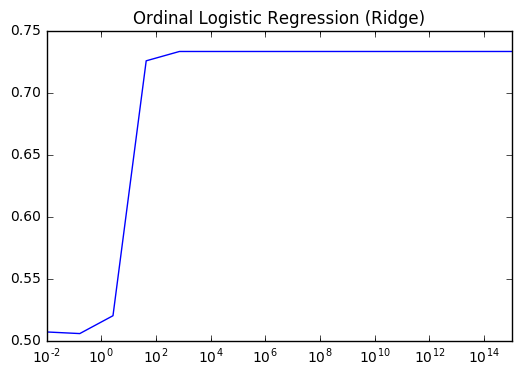

In [7]:
scores = []
i_vals = np.logspace(-2,15,15)
for i in i_vals:
    models = mord.OrdinalRidge(alpha=i, normalize=True)
    models.fit(X_train, y_train)
    y_pred = models.predict(X_test)
    scores.append(sklearn.metrics.mean_squared_error(y_test, y_pred))

plt.semilogx(i_vals, scores)
plt.title("Ordinal Logistic Regression (Ridge)")
plt.show()

In [23]:
mymodel = mord.OrdinalRidge(alpha=10000, fit_intercept=True, normalize=True, copy_X=True, max_iter=None, tol=0.001, solver='auto')
mymodel.fit(X_train, y_train)

y_pred = mymodel.predict(X_test)
print "Mean squared error regression loss:", sklearn.metrics.mean_squared_error(y_test, y_pred)

x = phoenix_update.drop('stars', axis=1)
sig_columns = x.columns[abs(mymodel.coef_) > 0.00005].values

Mean squared error regression loss: 0.733387888707


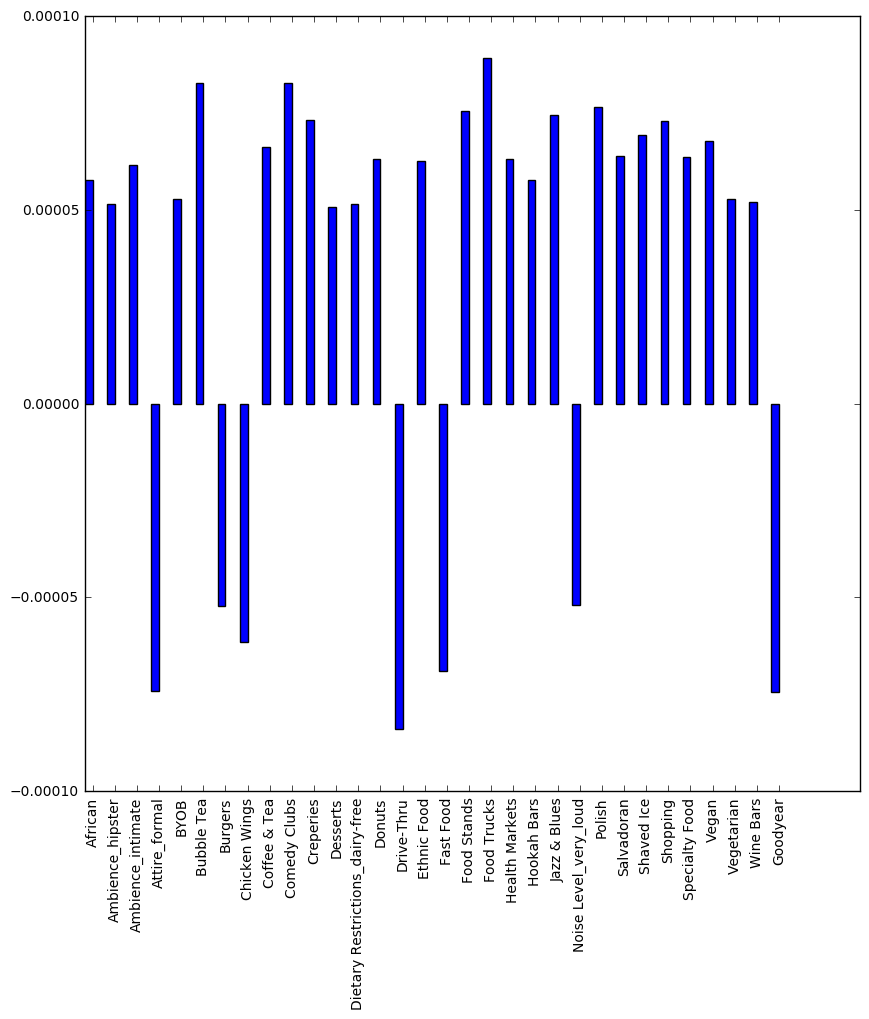

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ind = np.arange(len(mymodel.coef_[abs(mymodel.coef_ ) > 0.00005]))
width = 0.35
ax.bar(ind, mymodel.coef_[abs(mymodel.coef_) > 0.00005], width)
ax.set_xticks(ind + width)
ax.set_xticklabels(x.columns[abs(mymodel.coef_) > 0.00005])
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.show()

## Predicting user-rated stars
Because of a huge number of predictors in the businesses data set, first we used selected predictors that have larger abs(coefficient values) for predicting business stars. 

In [10]:
#Merge reviews and users
phoenix_reviews_users = phoenix_reviews.merge(phoenix_users, how='inner', on='user_id')
phoenix_reviews_users.head(2)

,user_id,business_id,year,month,day,stars,average_stars,compliments,elite,fans,friends,name,review_count,type,votes,yelping_since
0,547856,2377,2010,4,2,4,3.32,{'plain': 6},[],0,"[74751, 177590]",Gary,24,user,"{'cool': 14, 'useful': 36, 'funny': 26}",2008-11
1,547856,2377,2010,5,3,4,3.32,{'plain': 6},[],0,"[74751, 177590]",Gary,24,user,"{'cool': 14, 'useful': 36, 'funny': 26}",2008-11


In [47]:
##Reviews users data set
columns_of_interest2 =['user_id',
                       'business_id',
                       'year',
                       'month',
                       'day',
                       'stars',
                       'review_count'
                       #'yelping_since'
                      ]

phoenix_reviews_users_update = phoenix_reviews_users[columns_of_interest2]
#phoenix_reviews_users_update = pd.get_dummies(phoenix_reviews_users_update, columns=['yelping_since'], drop_first=True)
phoenix_reviews_users_update = phoenix_reviews_users_update.fillna(0)
phoenix_reviews_users_update.head(2)

,user_id,business_id,year,month,day,stars,review_count
0,547856,2377,2010,4,2,4,24
1,547856,2377,2010,5,3,4,24


In [48]:
#Merge all data sets
sig_columns2 = np.concatenate((sig_columns, np.array(['stars', 'business_id'])), axis = 0)
phoenix_update2 = phoenix_update[sig_columns2]
phoenix_update2 = phoenix_update2.rename(columns = {'stars': 'stars_business'})
df_all = phoenix_update2.merge(phoenix_reviews_users_update, how='inner', on='business_id')

In [49]:
def X_and_y_of(df):
    df_X = df.drop(['stars', 'stars_business', 'user_id', 'business_id'], axis=1)
    return df_X.values, df['stars'].values

all_train, all_test = train_test_split_reviews(df_all)

X_train, y_train = X_and_y_of(all_train)
X_test, y_test = X_and_y_of(all_test)

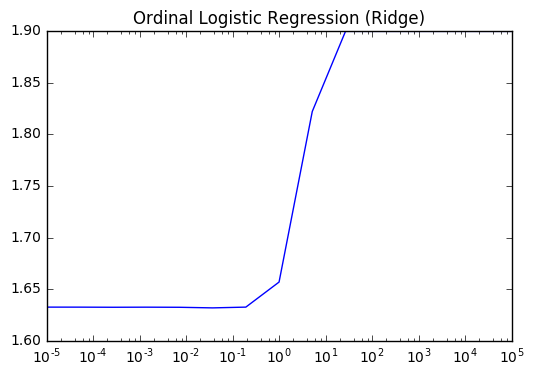

In [50]:
scores = []
i_vals = np.logspace(-5,5,15)
for i in i_vals:
    models = mord.OrdinalRidge(alpha=i, normalize=True)
    models.fit(X_train, y_train)
    y_pred = models.predict(X_test)
    scores.append(sklearn.metrics.mean_squared_error(y_test, y_pred))

plt.semilogx(i_vals, scores)
plt.title("Ordinal Logistic Regression (Ridge)")
plt.show()

In [51]:
mymodel = mord.OrdinalRidge(alpha=10**(-5), fit_intercept=True, normalize=True, copy_X=True, max_iter=None, tol=0.001, solver='auto')
mymodel.fit(X_train, y_train)

y_pred = mymodel.predict(X_test)
print "Mean squared error regression loss:", sklearn.metrics.mean_squared_error(y_test, y_pred)

x = phoenix_update.drop('stars', axis=1)
x.columns[abs(mymodel.coef_) > 0.00005]

Mean squared error regression loss: 1.63267091356


C:\Program Files\Anaconda2\lib\site-packages\pandas\indexes\base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 209 but corresponding boolean dimension is 37
  result = getitem(key)


Index([u'Accepts Credit Cards', u'Active Life', u'Adult Entertainment',
       u'African', u'Ages Allowed_21plus', u'Alcohol_beer_and_wine',
       u'Alcohol_full_bar', u'Alcohol_none', u'Ambience_casual',
       u'Ambience_classy', u'Ambience_divey', u'Ambience_hipster',
       u'Ambience_intimate', u'Ambience_romantic', u'Ambience_touristy',
       u'Ambience_trendy', u'Ambience_upscale', u'American (New)',
       u'American (Traditional)', u'Arcades', u'Arts & Entertainment',
       u'Asian Fusion', u'Attire_casual', u'Attire_dressy', u'Attire_formal',
       u'BYOB', u'BYOB/Corkage_no', u'BYOB/Corkage_yes_corkage',
       u'BYOB/Corkage_yes_free', u'Bagels', u'Bakeries', u'Barbeque', u'Bars',
       u'Beer, Wine & Spirits', u'Breakfast & Brunch', u'Breweries'],
      dtype='object')

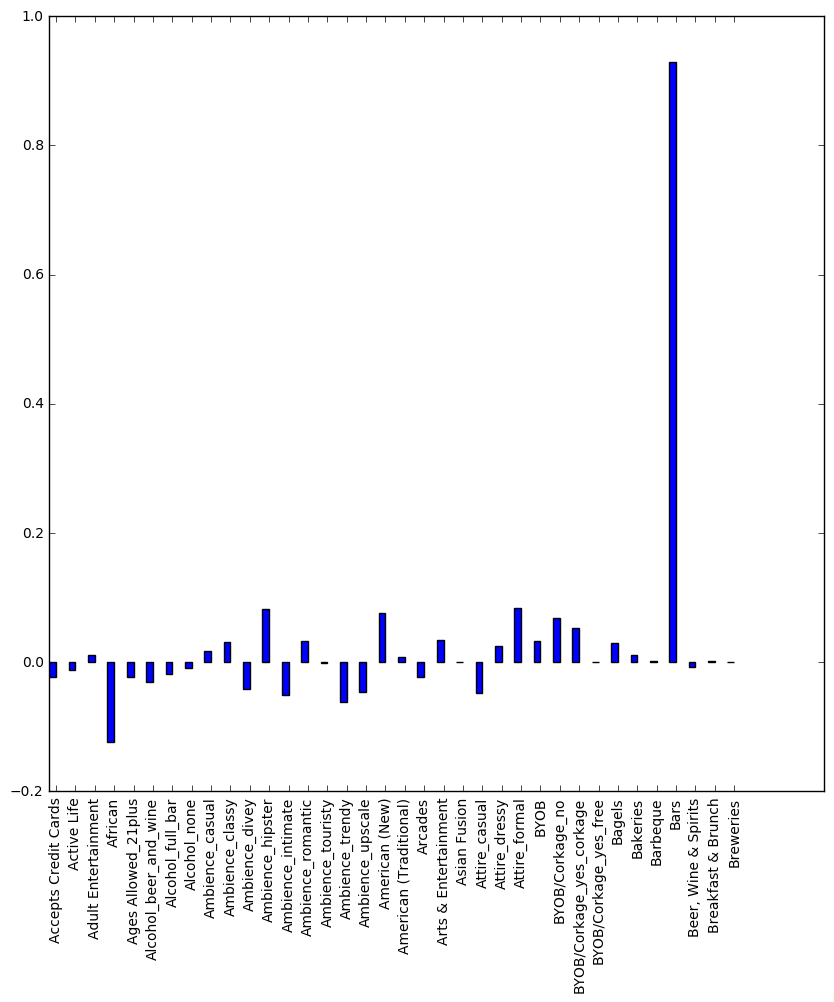

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ind = np.arange(len(mymodel.coef_[abs(mymodel.coef_ ) > 0.00005]))
width = 0.35
ax.bar(ind, mymodel.coef_[abs(mymodel.coef_) > 0.00005], width)
ax.set_xticks(ind + width)
ax.set_xticklabels(x.columns[abs(mymodel.coef_) > 0.00005])
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.show()